# Model a Snail - A simple Neural Network

### Python Future imports for compatibility with python2

In [1]:
import sys

from __future__ import print_function, division

### Import Keras, and other necessary libraries

In [2]:
%matplotlib inline


import tensorflow
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import  optimizers

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


### Version Check

In [3]:
print("Keras " , keras.__version__)
print("tensorflow, ", tensorflow.__version__)
print("python", sys.version)

Keras  2.0.5
tensorflow,  1.2.1
python 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Load the Data - Snail has 2 features, to decide to eat or not

In DSX, loading data from Hadoop / DB / File is a 1-click effort

In [4]:
from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_83e2982aad4a45028646908cf6f66a34(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_3f133a8de2c21a8e78af3a543c7f3e34f9325181','domain': {'id': '7391f1fa1cfc4a8d88043ba41bef8e1f'},
            'password': 'u[I095R}ICvk6m)w'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_83e2982aad4a45028646908cf6f66a34('TrainaSnail', 'snail_experiment_10000.csv'))
df_data_2.head()


,hunger,food,action
0,0.054849,0.996620,pass
1,0.170089,0.795212,eat
2,0.767761,0.754398,eat
3,0.360207,0.571926,pass
4,0.017384,0.630184,pass


In [5]:
snail_data = df_data_2

### A hungry signal, and a food-within-range signal, will decide if the Snail will eat

In [6]:
snail_data.head(5)

,hunger,food,action
0,0.054849,0.996620,pass
1,0.170089,0.795212,eat
2,0.767761,0.754398,eat
3,0.360207,0.571926,pass
4,0.017384,0.630184,pass


# Create Test and Train set

In [7]:
msk = np.random.rand(len(snail_data)) < 0.8

train = snail_data[msk]
test = snail_data[~msk]

In [8]:
# data preprocessing
Y_train = to_categorical( 1 * (train["action"] == "eat") )
Y_test = to_categorical( 1 * (test["action"] == "eat") )
X_train = train[["hunger","food"]].values
X_test = test[["hunger","food"]].values

# Jupyter Notebooks can live Plot - This code is to live see the training curve

In [23]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure()
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# Here we design our Neural Network, and select optimizer with Learning Rate

- Change the learning rate to see the effect.
- Add a few more layers
- Change the activation function

In [33]:
model = Sequential()
model.add(Dense(2, activation='sigmoid', input_dim=2))

sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.layers[0].get_weights()

[array([[ 1.15969074,  0.98792207],
        [ 0.4792403 , -1.12596357]], dtype=float32),
 array([ 0.,  0.], dtype=float32)]

# The actual training happens with the fit() 

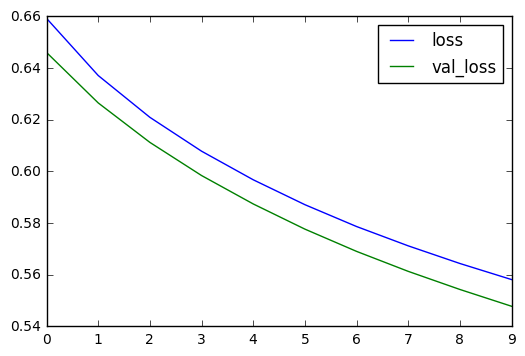

In [35]:
model.fit(X_train, Y_train,
          epochs=10,
          validation_data=(X_test, Y_test),
          callbacks=[plot_losses],
          verbose=0)

# We can now use our trained network to check some cases

### Snail is very hungry, but food is out of reach

In [36]:
model.predict_classes( np.array([[1,  .1]]) , verbose=1)

1/1 [==============================] - 0s


array([0])

### Snail is not that hungry, but food is within reach

In [37]:
model.predict_classes( np.array([[.55,  .9]]) , verbose=1)

1/1 [==============================] - 0s


array([0])

### Snail is not hungry, food is below him

In [38]:
model.predict_classes( np.array([[.3,  1.0]]) , verbose=1)

1/1 [==============================] - 0s


array([0])